In [1]:
from data.dataset_loader import load_bcw_dataset
from tree.DecisionTree import DecisionTree
from utils.plot_tree import plot_tree
from utils.full_evaluation import run_full_evaluation
from utils.metrics import compute_metrics
from utils.plotting import (
    plot_train_val_accuracy,
    plot_tree_complexity,
    plot_overfitting,
)
from utils.analysis import hyperparameter_tuning
from utils.evaluate_tree import evaluate_tree
from utils.feature_importance import compute_feature_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
(X_train, y_train, X_val, y_val, X_test, y_test, feature_names, target_names) = (
    load_bcw_dataset()
)

# Dataset Summary
print(f"Train size      : {len(X_train)} samples")
print(f"Validation size : {len(X_val)} samples")
print(f"Test size       : {len(X_test)} samples")
print()
print(f"Number of features : {len(feature_names)}")
print(f"Feature names      : {list(feature_names)}")
print(f"Target classes     : {list(target_names)}")

Train size      : 397 samples
Validation size : 86 samples
Test size       : 86 samples

Number of features : 30
Feature names      : ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Target classes     : ['malignant', 'benign']


In [3]:
# Initialize the tree
tree = DecisionTree(max_depth=6, min_samples_split=5)

# Train on training set
tree.fit(X_train, y_train)

# Plot the tree
target_classes = ["malignant", "benign"]  # 0 -> malignant, 1 -> benign
tree.plot(feature_names=feature_names, class_names=target_classes)
print("Decision tree plot saved as 'tree_output.png'")

Decision tree plot saved as 'tree_output.png'


In [4]:
# Hyperparameter tuning
max_depth_values = [2, 4, 6, 8, 10]
min_samples_split_values = [2, 5, 10]

results_df, models = hyperparameter_tuning(
    X_train,
    y_train,
    X_val,
    y_val,
    max_depth_values,
    min_samples_split_values,
)
print("Hyperparameter tuning results:")
print(results_df)

# Pick best hyperparameters (highest validation accuracy)
best_row = results_df.loc[results_df["val_acc"].idxmax()]
best_max_depth = int(best_row["max_depth"])
best_min_samples_split = int(best_row["min_samples_split"])
print("Best hyperparameters:", best_max_depth, best_min_samples_split)

Hyperparameter tuning results:
    max_depth  min_samples_split  train_acc   val_acc
0           2                  2   0.926952  0.930233
1           2                  5   0.926952  0.930233
2           2                 10   0.926952  0.930233
3           4                  2   0.987406  0.965116
4           4                  5   0.982368  0.953488
5           4                 10   0.977330  0.965116
6           6                  2   1.000000  0.965116
7           6                  5   0.992443  0.953488
8           6                 10   0.982368  0.965116
9           8                  2   1.000000  0.965116
10          8                  5   0.992443  0.953488
11          8                 10   0.982368  0.965116
12         10                  2   1.000000  0.965116
13         10                  5   0.992443  0.953488
14         10                 10   0.982368  0.965116
Best hyperparameters: 4 2


Best decision tree plot saved as 'best_tree_output.png'
Test Set Performance

Overall Accuracy: 0.9419

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.864865  1.000000  0.927536
benign      1.000000  0.907407  0.951456


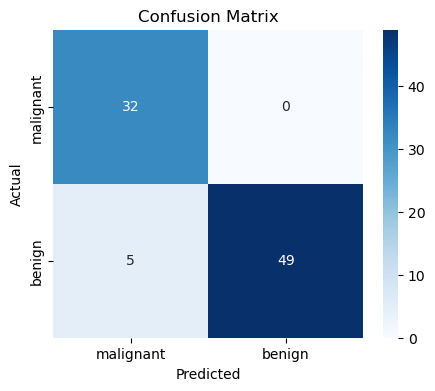

In [5]:
# Retrain on train + validation
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])
best_tree = DecisionTree(
    max_depth=best_max_depth, min_samples_split=best_min_samples_split
)
best_tree.fit(X_train_val, y_train_val)
best_tree.plot(
    feature_names=feature_names, class_names=target_classes, filename="best_tree_output"
)
print("Best decision tree plot saved as 'best_tree_output.png'")

# Evaluate on test
test_preds = best_tree.predict(X_test)
metrics = compute_metrics(y_test, test_preds, class_names=target_classes)
metrics = evaluate_tree(best_tree, X_test, y_test, class_names=target_classes)


Accuracy Summary (min_samples_split=2)
 Max Depth |  Train Accuracy |  Validation Accuracy
--------------------------------------------------
         2 |          92.70% |               93.02%
         4 |          98.74% |               96.51%
         6 |         100.00% |               96.51%
         8 |         100.00% |               96.51%
        10 |         100.00% |               96.51%


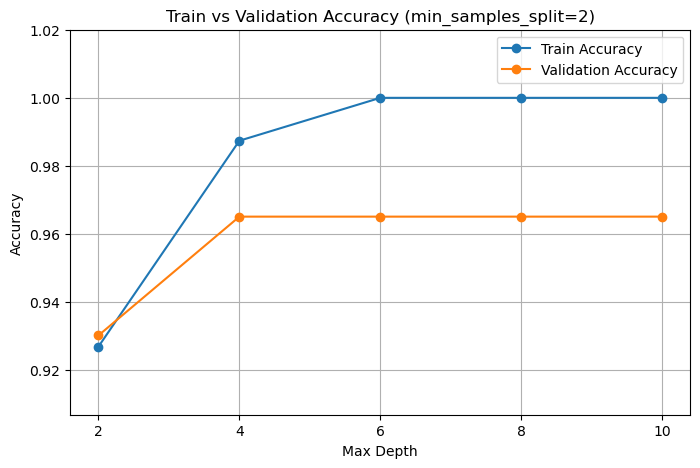

In [6]:
# Plot train vs validation accuracy for fixed min_samples_split
plot_train_val_accuracy(results_df, min_samples_split_fixed=best_min_samples_split)

In [ ]:
# Feature importance
print("Feature Importances:")
feature_importances = compute_feature_importance(best_tree, feature_names=feature_names)

Feature Importances:
                Feature  Importance
7   mean concave points    1.000000
0          worst radius    0.566302
5          mean texture    0.510487
4      mean compactness    0.407468
6      worst smoothness    0.383684
1  worst concave points    0.225413
2            area error    0.031807
3         worst texture    0.021552
                Feature  Importance
7   mean concave points    1.000000
0          worst radius    0.566302
5          mean texture    0.510487
4      mean compactness    0.407468
6      worst smoothness    0.383684
1  worst concave points    0.225413
2            area error    0.031807
3         worst texture    0.021552


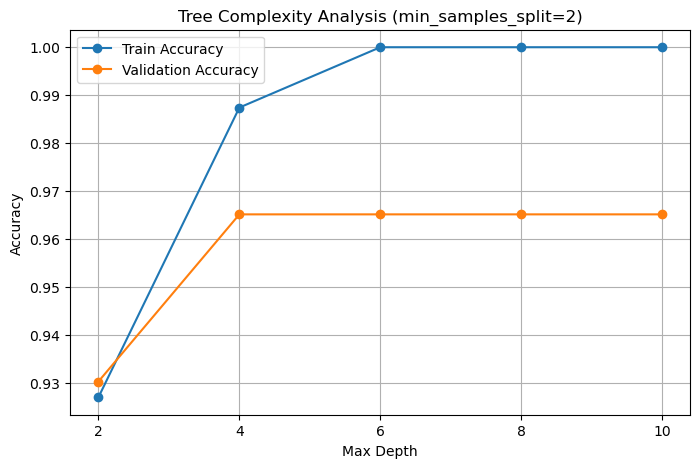


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


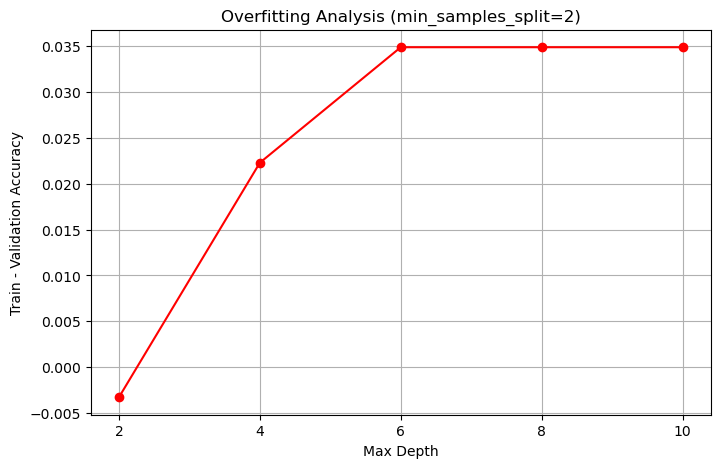


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884


In [8]:
plot_tree_complexity(results_df, best_min_samples_split)
plot_overfitting(results_df, best_min_samples_split)


================ FULL EVALUATION FOR ALL MODELS ================


-------------------------------------------------------------
 MODEL: max_depth=2, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9186

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.903226  0.875000  0.888889
benign      0.927273  0.944444  0.935780


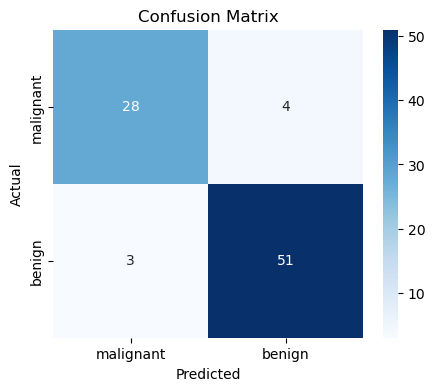



================ FEATURE IMPORTANCE ================

                Feature  Importance
0       worst perimeter    0.557041
1  worst concave points    0.371103


================ TREE COMPLEXITY ANALYSIS ================



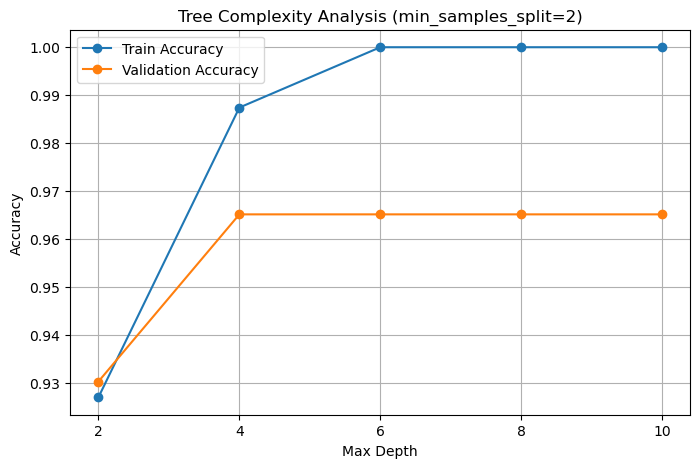


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



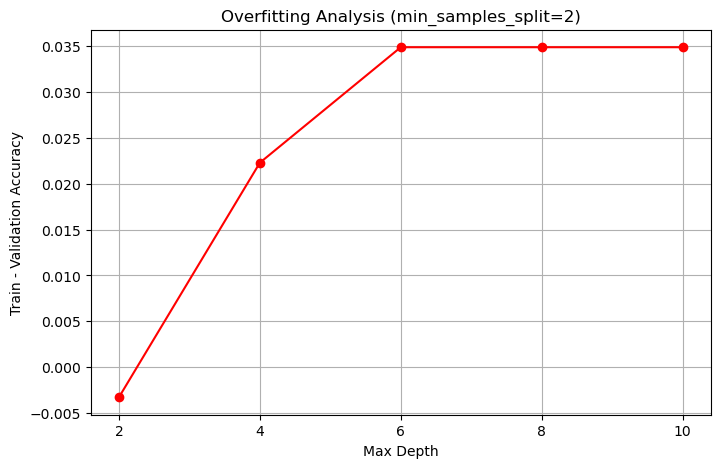


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=2, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9186

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.903226  0.875000  0.888889
benign      0.927273  0.944444  0.935780


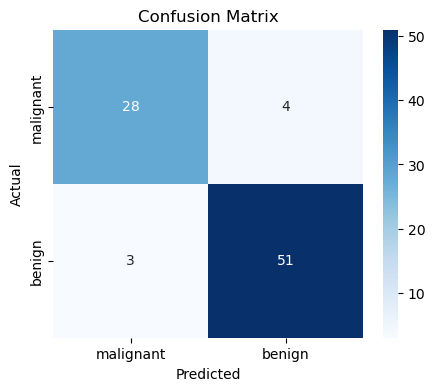



================ FEATURE IMPORTANCE ================

                Feature  Importance
0       worst perimeter    0.557041
1  worst concave points    0.371103


================ TREE COMPLEXITY ANALYSIS ================



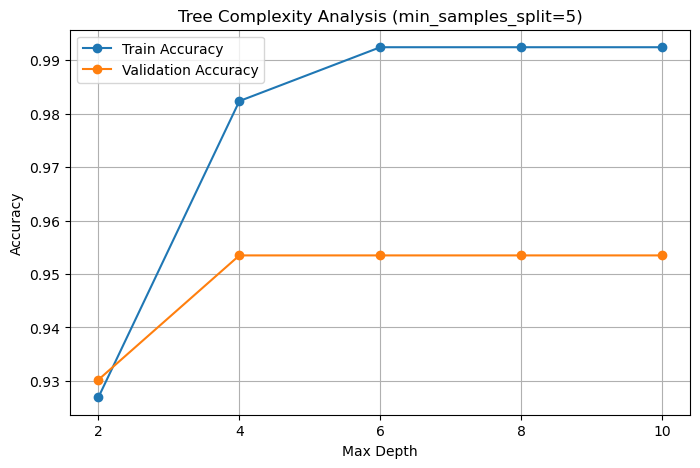


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



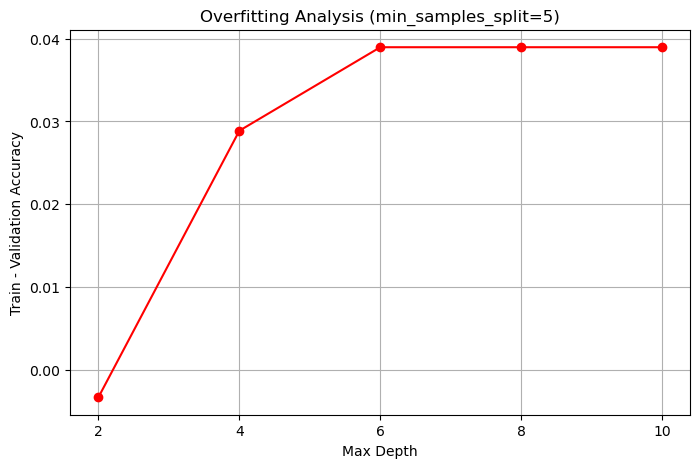


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=2, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9186

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.903226  0.875000  0.888889
benign      0.927273  0.944444  0.935780


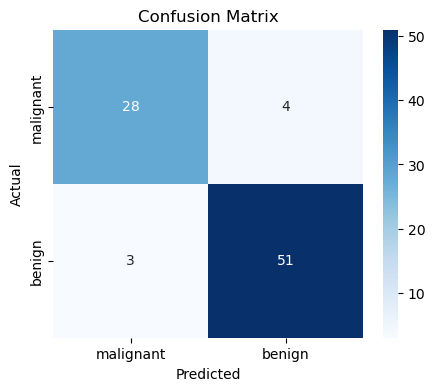



================ FEATURE IMPORTANCE ================

                Feature  Importance
0       worst perimeter    0.557041
1  worst concave points    0.371103


================ TREE COMPLEXITY ANALYSIS ================



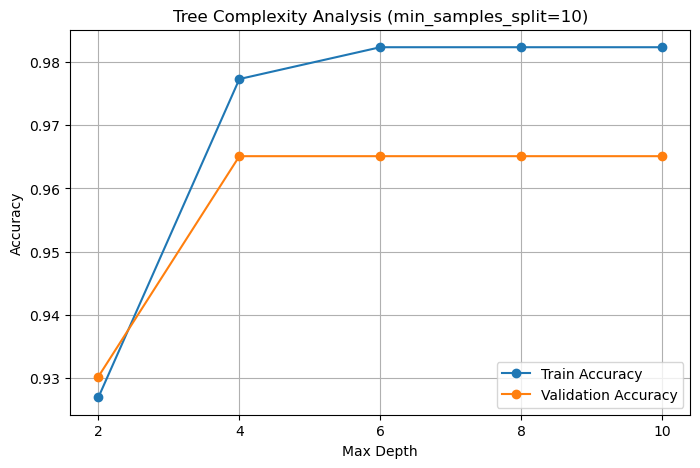


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



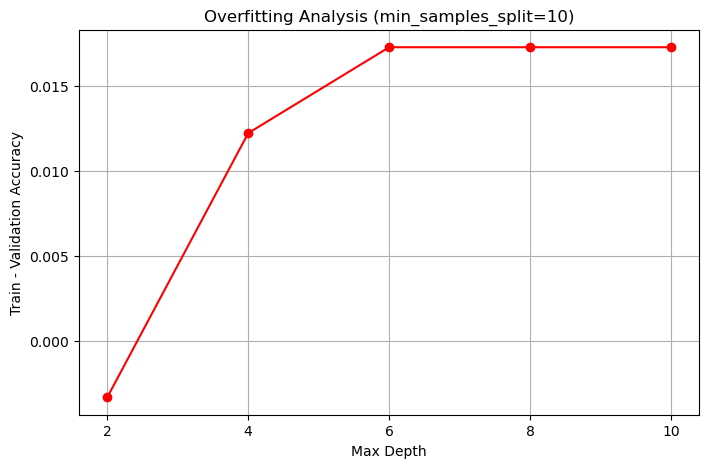


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=4, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


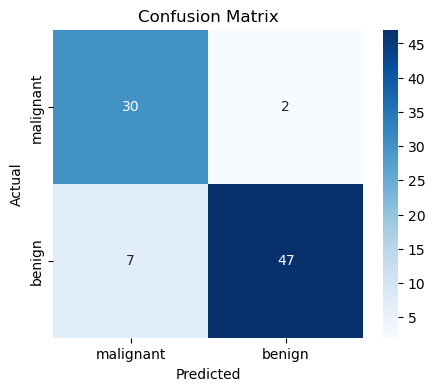



================ FEATURE IMPORTANCE ================

                   Feature  Importance
4         mean compactness    1.000000
7              mean radius    0.764205
0          worst perimeter    0.557041
5             worst radius    0.406431
3            worst texture    0.384667
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



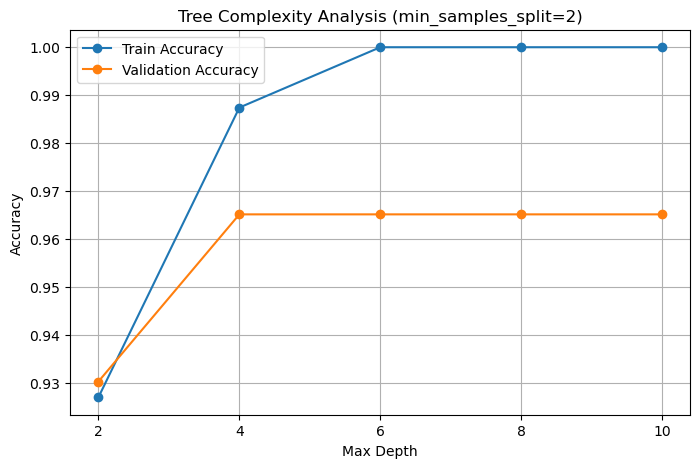


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



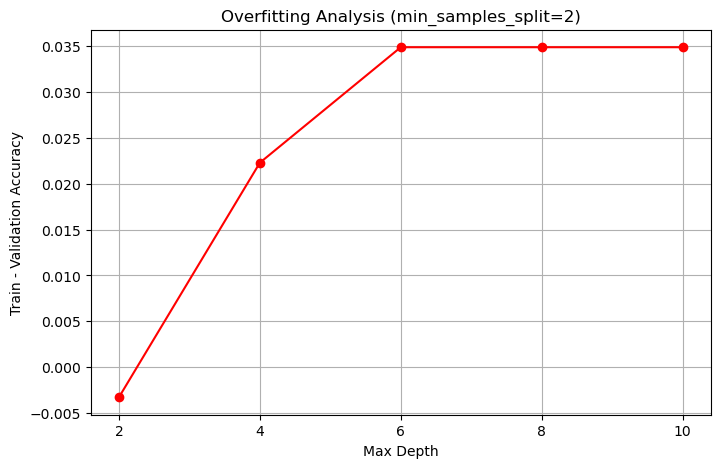


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=4, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


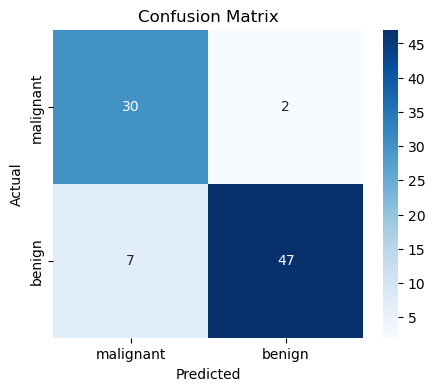



================ FEATURE IMPORTANCE ================

                   Feature  Importance
6              mean radius    0.764205
0          worst perimeter    0.557041
4             worst radius    0.406431
3            worst texture    0.384667
1     worst concave points    0.371103
5  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



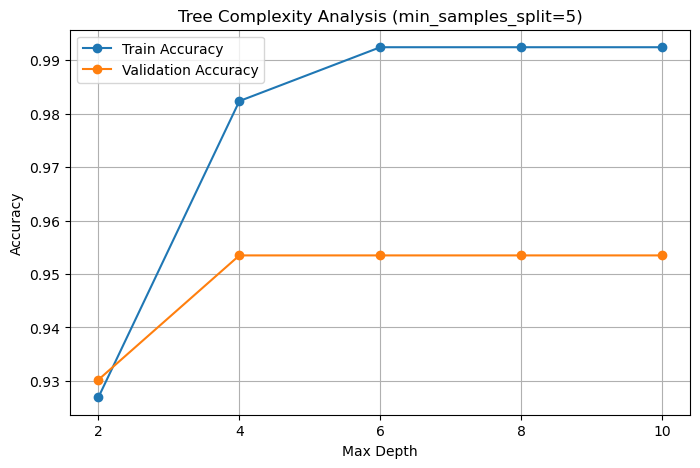


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



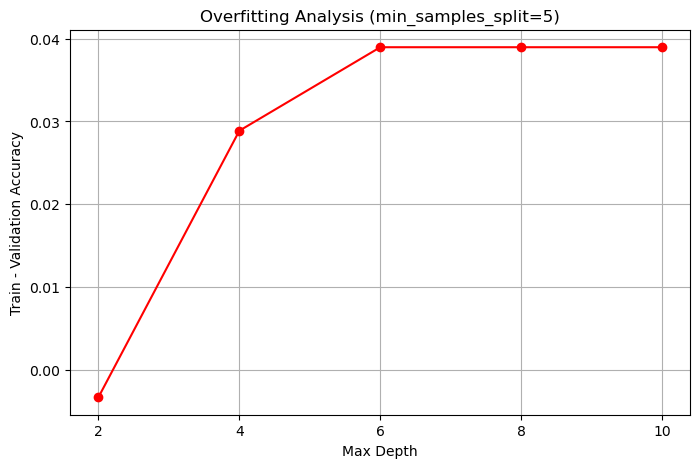


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=4, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


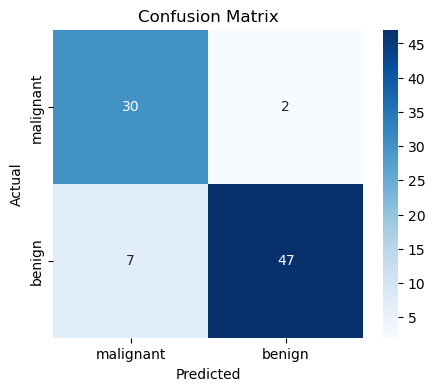



================ FEATURE IMPORTANCE ================

                   Feature  Importance
0          worst perimeter    0.557041
4             worst radius    0.406431
3            worst texture    0.384667
1     worst concave points    0.371103
5  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



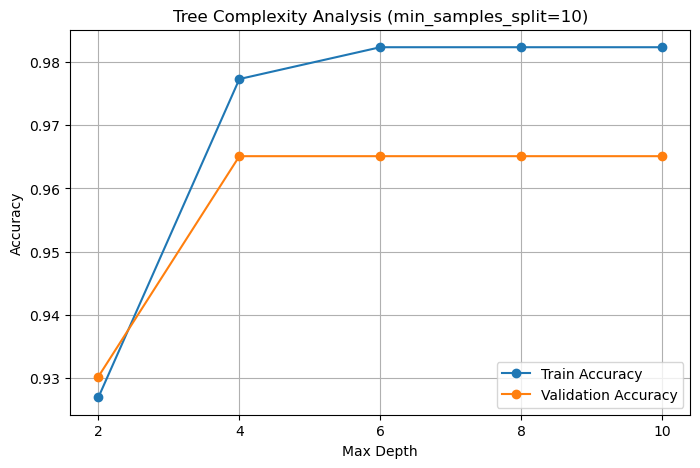


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



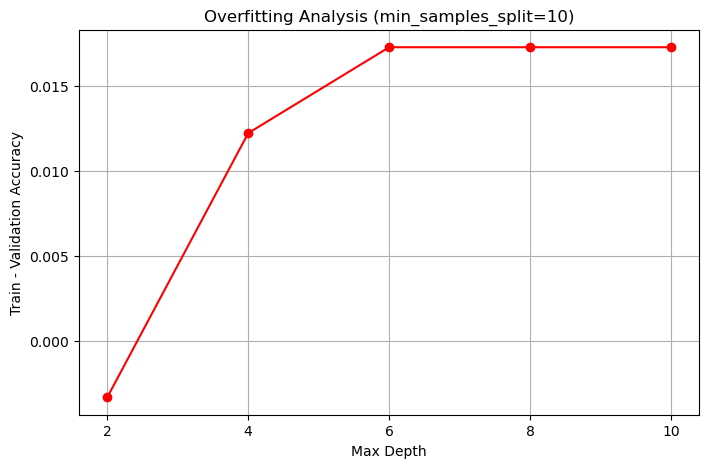


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=6, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


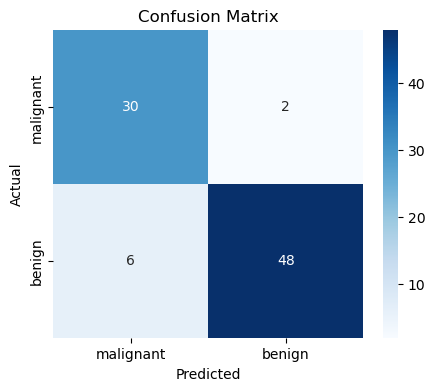



================ FEATURE IMPORTANCE ================

                   Feature  Importance
8              mean radius    1.682500
6         worst smoothness    1.061160
4         mean compactness    1.000000
3            worst texture    0.707424
0          worst perimeter    0.557041
5             worst radius    0.406431
1     worst concave points    0.371103
7  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



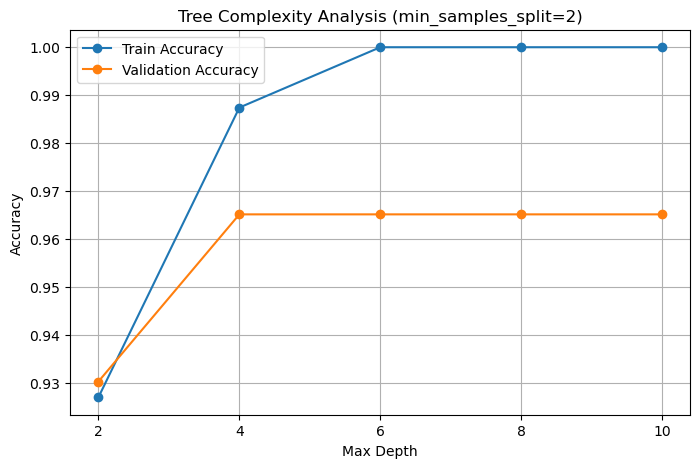


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



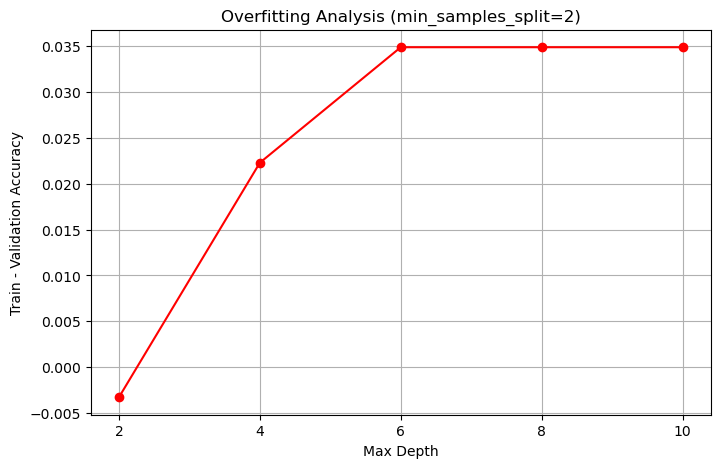


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=6, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


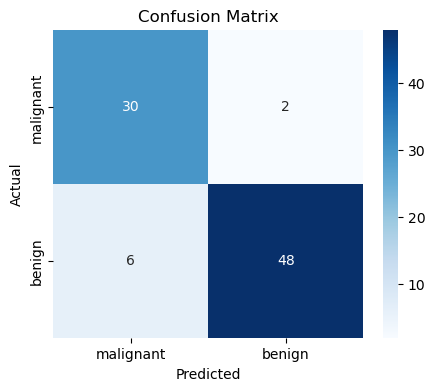



================ FEATURE IMPORTANCE ================

                   Feature  Importance
5         worst smoothness    1.061160
7              mean radius    0.764205
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



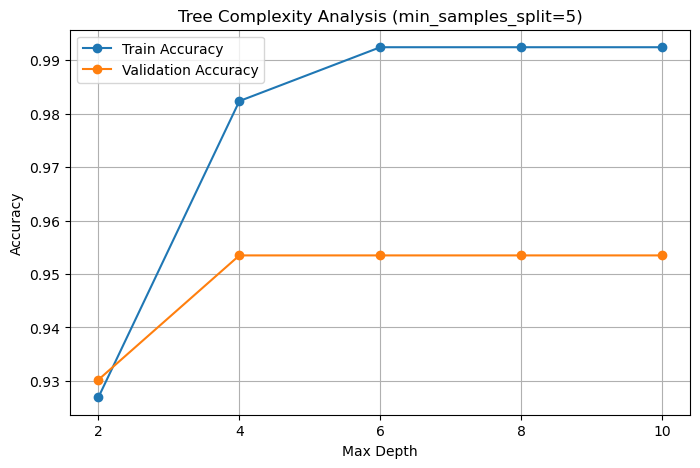


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



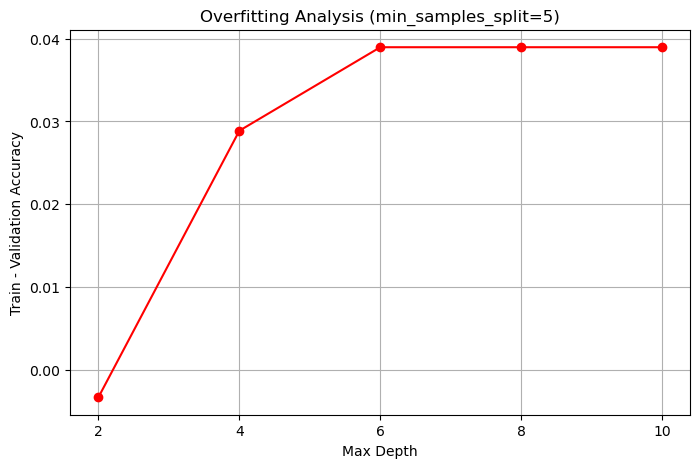


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=6, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


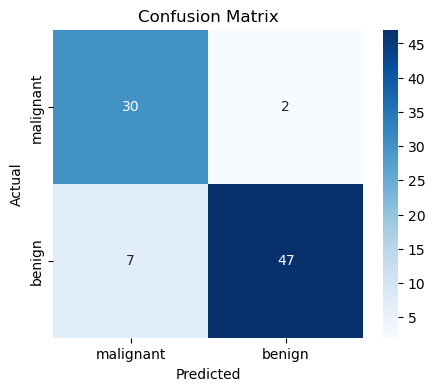



================ FEATURE IMPORTANCE ================

                   Feature  Importance
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
5         worst smoothness    0.249882
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



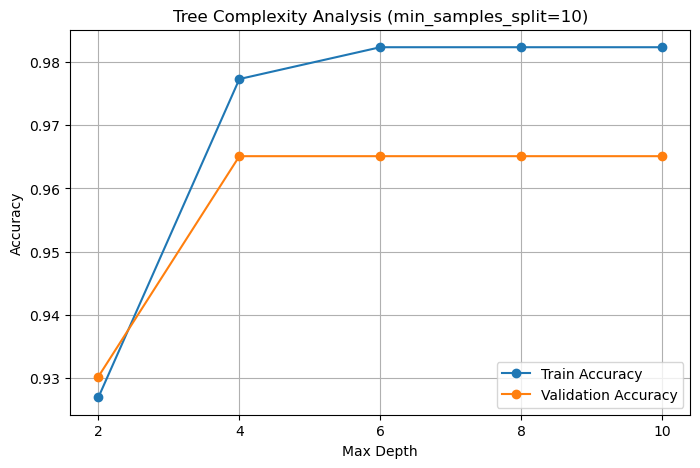


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



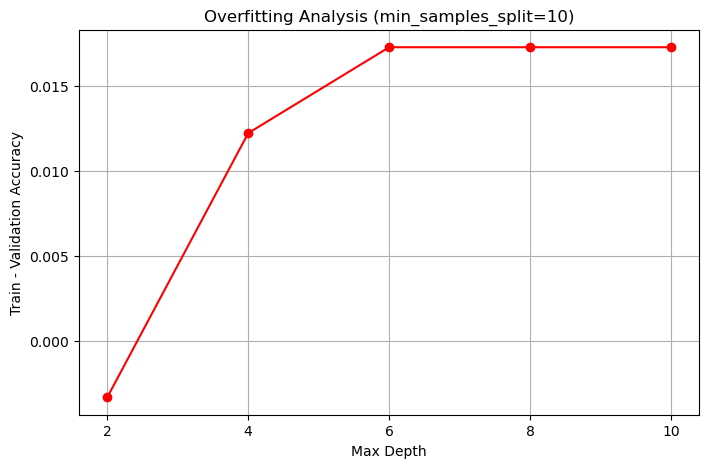


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=8, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


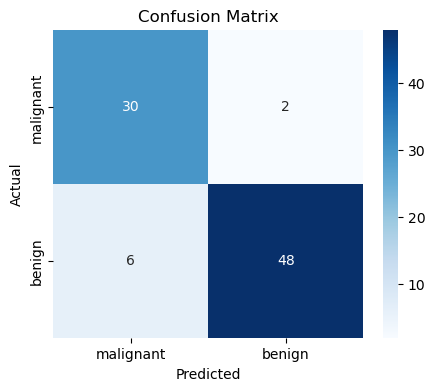



================ FEATURE IMPORTANCE ================

                   Feature  Importance
8              mean radius    1.682500
6         worst smoothness    1.061160
4         mean compactness    1.000000
3            worst texture    0.707424
0          worst perimeter    0.557041
5             worst radius    0.406431
1     worst concave points    0.371103
7  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



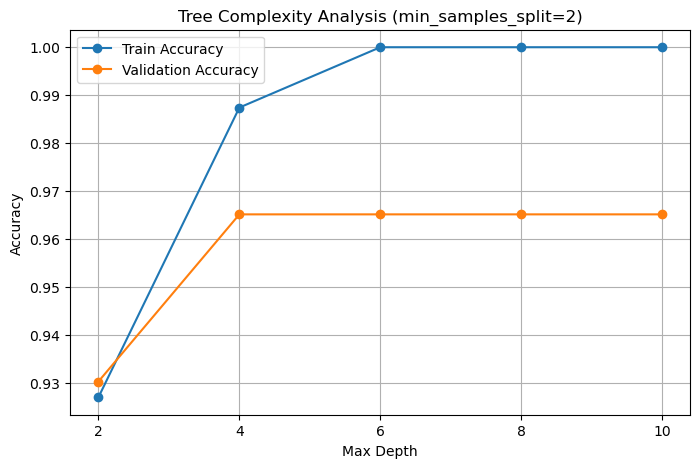


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



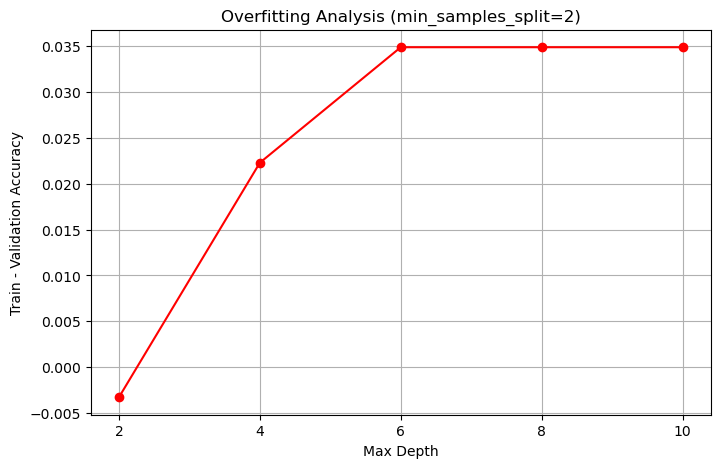


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=8, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


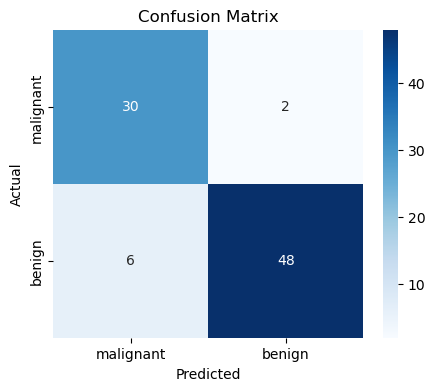



================ FEATURE IMPORTANCE ================

                   Feature  Importance
5         worst smoothness    1.061160
7              mean radius    0.764205
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



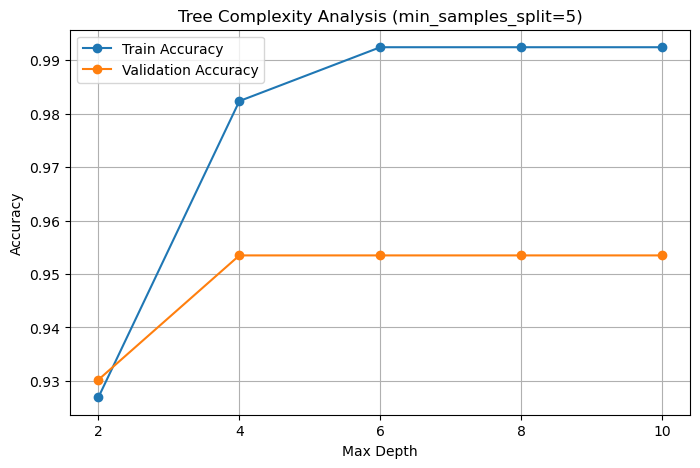


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



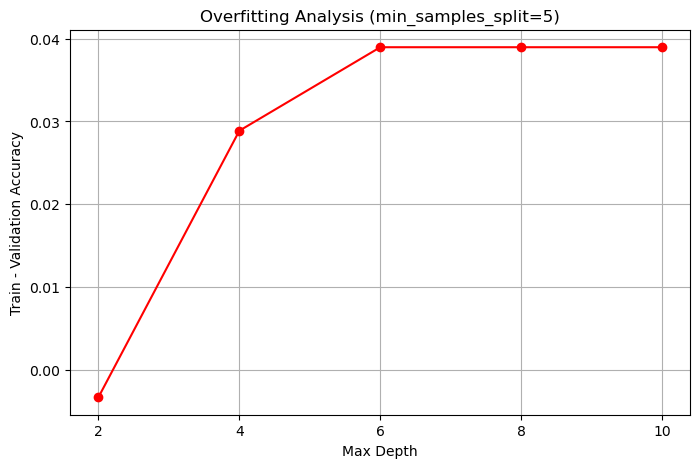


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=8, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


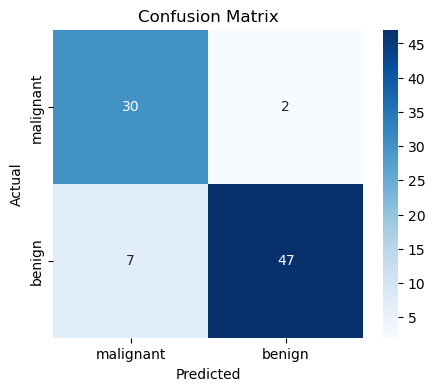



================ FEATURE IMPORTANCE ================

                   Feature  Importance
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
5         worst smoothness    0.249882
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



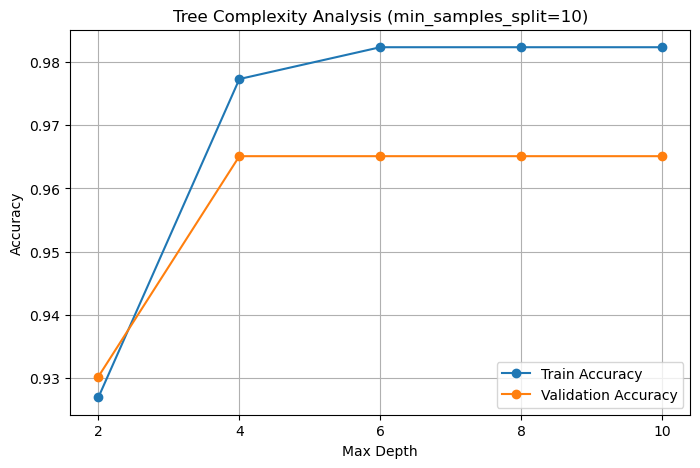


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



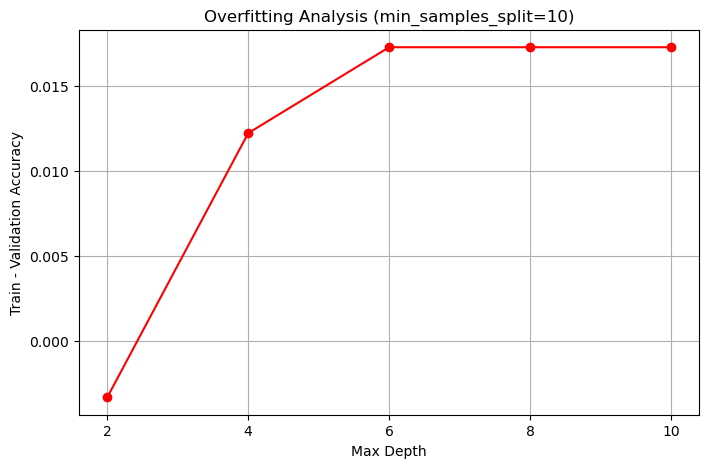


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=10, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


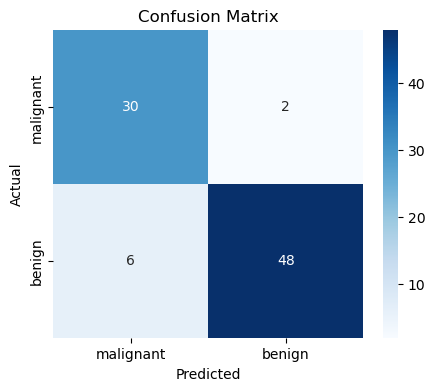



================ FEATURE IMPORTANCE ================

                   Feature  Importance
8              mean radius    1.682500
6         worst smoothness    1.061160
4         mean compactness    1.000000
3            worst texture    0.707424
0          worst perimeter    0.557041
5             worst radius    0.406431
1     worst concave points    0.371103
7  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



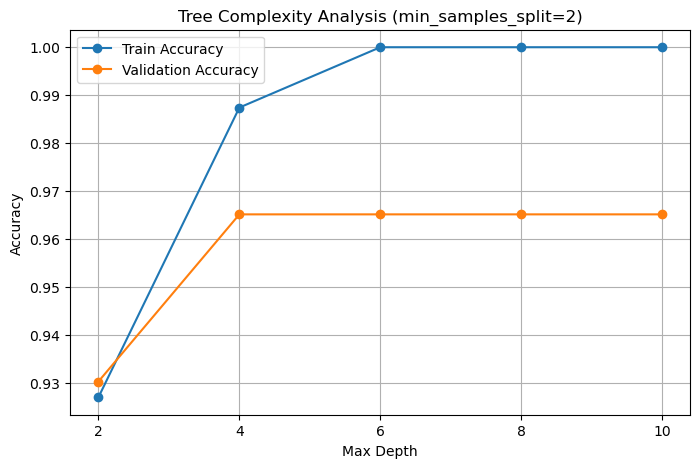


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



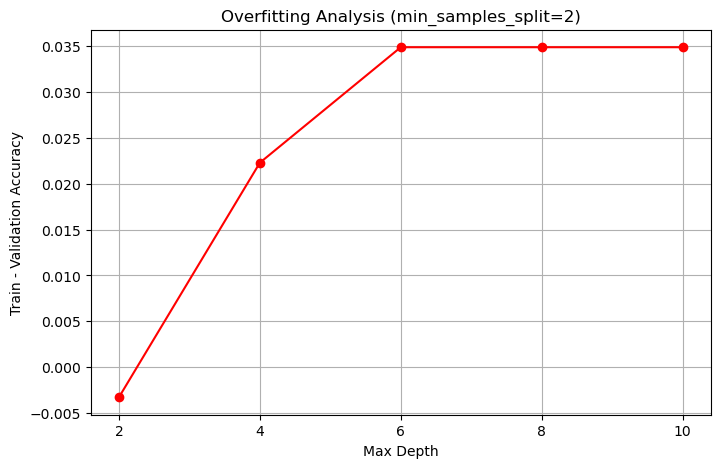


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=10, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


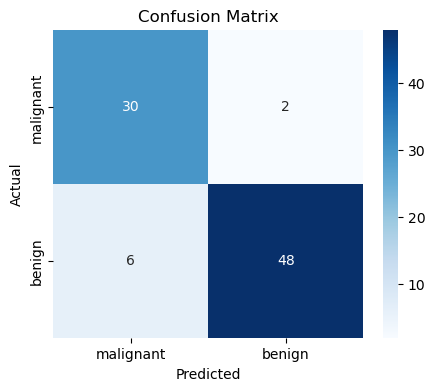



================ FEATURE IMPORTANCE ================

                   Feature  Importance
5         worst smoothness    1.061160
7              mean radius    0.764205
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



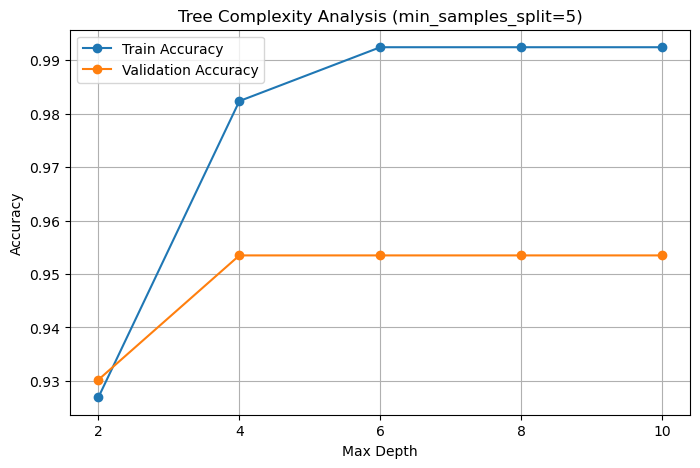


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



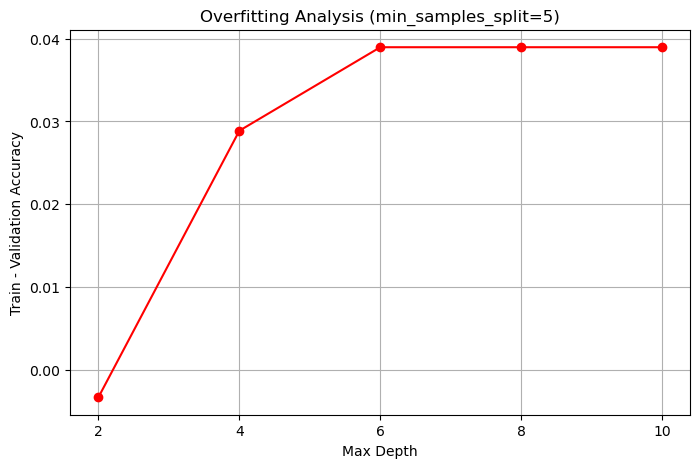


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=10, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


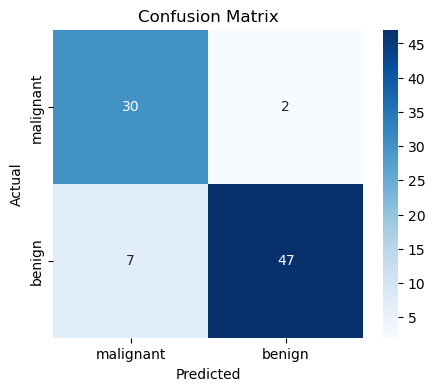



================ FEATURE IMPORTANCE ================

                   Feature  Importance
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
5         worst smoothness    0.249882
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



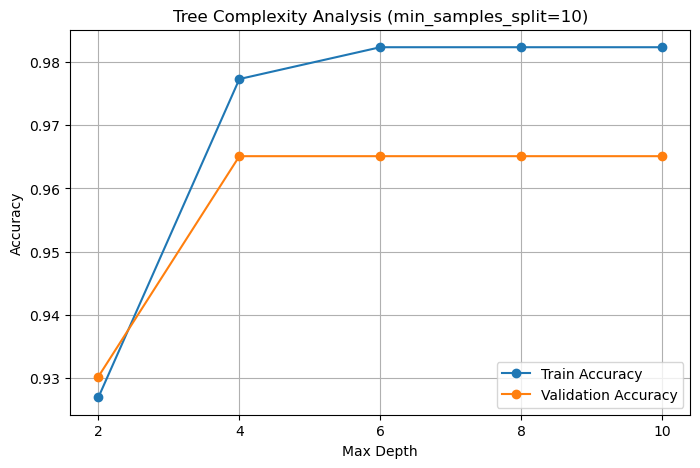


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



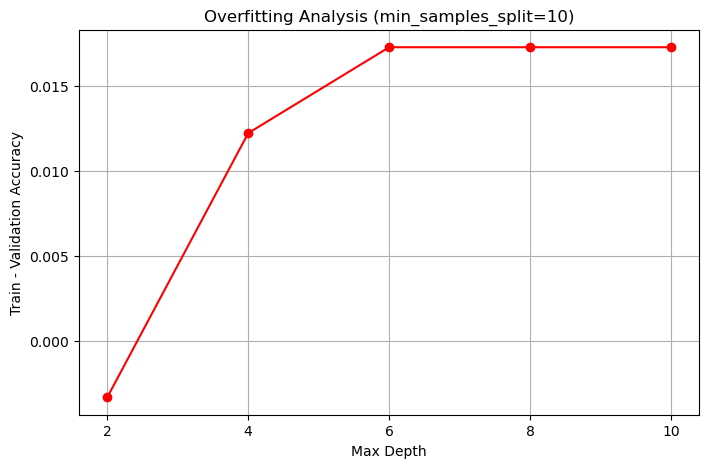


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

================ END OF FULL EVALUATION ================



In [9]:
# Analysis and Final Evaluation
run_full_evaluation(
    models,
    X_test,
    y_test,
    feature_names,
    target_names,
    results_df
)